In [26]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from tikz import Picture, line, rectangle, coordinate


from aqmsp_data.data import load_caaqm, load_station_ds, load_camx, load_shapefile
from aqmsp_data.utils import get_closest_data_from_camx

In [9]:
station_ds = load_station_ds()
delhi = load_caaqm(years=2022, months=1)
delhi = delhi.sel(station=station_ds.station.values).load()
delhi


<xarray.Dataset>
Dimensions:    (station: 38, time: 744)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2022-01-31T23:30:00
    latitude   (station) float64 28.82 28.65 28.7 28.47 ... 28.53 28.67 28.7
    longitude  (station) float64 77.15 77.32 77.18 77.11 ... 77.19 77.32 77.17
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] 2022-01-01 ... 2022-01-31T23:00:00
    To Date    (station, time) datetime64[ns] 2022-01-01T01:00:00 ... 2022-02-01
    PM2.5      (station, time) float64 219.5 224.5 217.0 ... 348.0 324.2 309.2
    PM10       (station, time) float64 342.8 360.2 359.0 ... 553.0 497.8 463.8
    NO         (station, time) float64 94.73 89.3 50.08 ... 65.58 64.15 82.05
    NO2        (station, time) float64 53.95 44.7 48.2 ... 29.67 28.07 23.95
    ...         ...
    WD         (station, time) float64 205.9 206.1 205.4 ... 106.5 100.1 87.93
    SR         (station, time) float64 4.6 4.6 4.62 4.62 ... 5.55 5.5 5.5 5.53
    BP         (station, time) float64 999.1 998.9 998.7 ... 989.7 989.8 989.8
    AT         (station, time) float64 6.85 6.72 6.97 6.72 ... 13.97 13.75 13.5
    RF         (station, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    TOT-RF     (station, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [10]:
camx = load_camx(years=2022, months=1).load()
camx

/home/patel_zeel/miniconda3/lib/python3.9/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


<xarray.Dataset>
Dimensions:    (longitude: 80, time: 744, latitude: 80)
Coordinates:
  * longitude  (longitude) float64 76.85 76.86 76.87 76.88 ... 77.62 77.63 77.64
  * latitude   (latitude) float64 28.2 28.21 28.22 28.23 ... 28.97 28.98 28.99
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2022-01-31T23:30:00
Data variables:
    P10        (time, latitude, longitude) float32 135.4 135.4 ... 163.5 163.5
    P25        (time, latitude, longitude) float32 115.8 115.8 ... 159.0 159.0
Attributes: (12/34)
    CDATE:          2023126
    CTIME:          95909
    EXEC_ID:        ????????????????                                         ...
    FILEDESC:       I/O API formatted CAMx AVRG output                       ...
    FTYPE:          1
    GDNAM:          ????????????????
    ...             ...
    XCELL:          0.009999999776482582
    XCENT:          0.0
    XORIG:          76.8499984741211
    YCELL:          0.009999999776482582
    YCENT:          0.0
    YORIG:          28.200000762939453

In [11]:
closest_camx = get_closest_data_from_camx(camx, k=25)
closest_camx

100%|██████████| 38/38 [00:00<00:00, 172.86it/s]


<xarray.Dataset>
Dimensions:    (station: 38, time: 744)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2022-01-31T23:30:00
    latitude   (station) float64 28.82 28.65 28.7 28.47 ... 28.53 28.67 28.7
    longitude  (station) float64 77.15 77.32 77.18 77.11 ... 77.19 77.32 77.17
Data variables:
    P10        (station, time) float32 153.9 129.5 96.95 ... 377.8 352.0 353.9
    P25        (station, time) float32 132.9 113.3 82.87 ... 233.5 236.8 264.6

0.46525383305739015


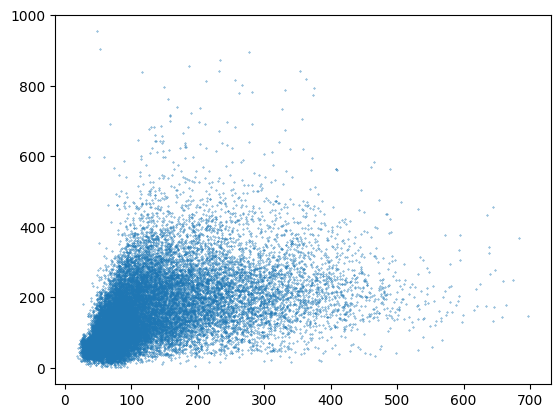

In [12]:
isna = np.isnan(delhi["PM2.5"].values.ravel()) | np.isnan(
    closest_camx["P25"].values.ravel()
)
caaqm_data = delhi["PM2.5"].values.ravel()[~isna]
camx_data = closest_camx["P25"].values.ravel()[~isna]
print(np.corrcoef(caaqm_data, camx_data)[0, 1])

plt.scatter(camx_data, caaqm_data, s=0.1)

<AxesSubplot:>

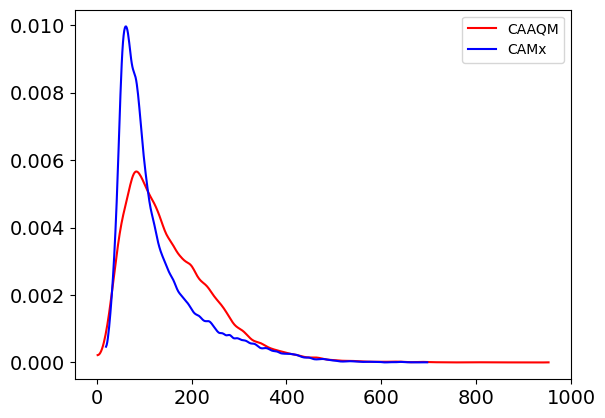

In [13]:
delhi_data = delhi["PM2.5"].values.ravel()
az.plot_dist(delhi["PM2.5"].values.ravel(), label="CAAQM", color="r")
az.plot_dist(closest_camx["P25"].values.ravel(), label="CAMx", color="b")


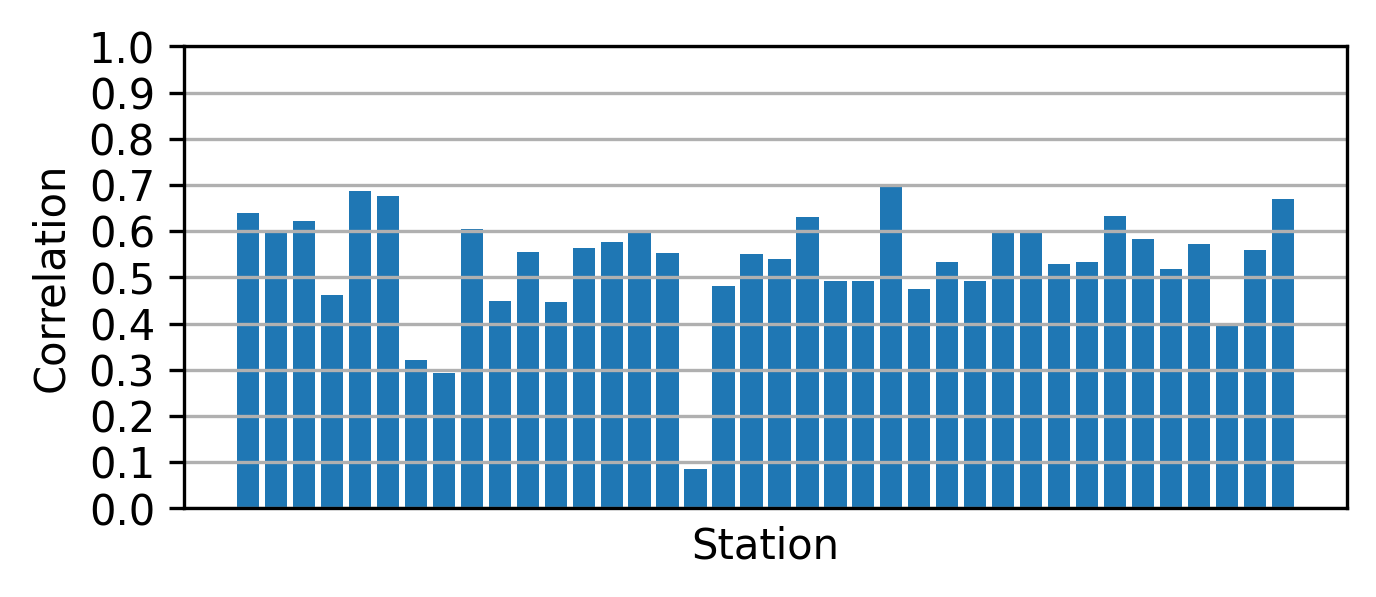

In [14]:
corr_list = []
for station in station_ds.station.values:
    caaqm_data = delhi["PM2.5"].sel(station=station).values.ravel()
    camx_data = closest_camx["P25"].sel(station=station).values.ravel()
    isna = np.isnan(caaqm_data) | np.isnan(camx_data)
    caaqm_data = caaqm_data[~isna]
    camx_data = camx_data[~isna]
    corr_list.append(np.corrcoef(caaqm_data, camx_data)[0, 1])
corr_list = np.array(corr_list)
plt.figure(figsize=(5, 2), dpi=300)
plt.bar(range(len(corr_list)), corr_list)
plt.xticks([])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Correlation")
plt.xlabel("Station")
plt.ylim(0, 1)
plt.grid()
plt.show()


In [15]:
np.mean(corr_list), np.std(corr_list)

(0.534271651661739, 0.11625214603263577)

<AxesSubplot:>

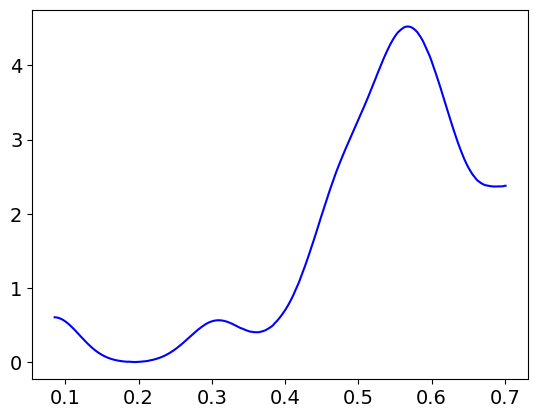

In [16]:
az.plot_dist(corr_list, color="b")


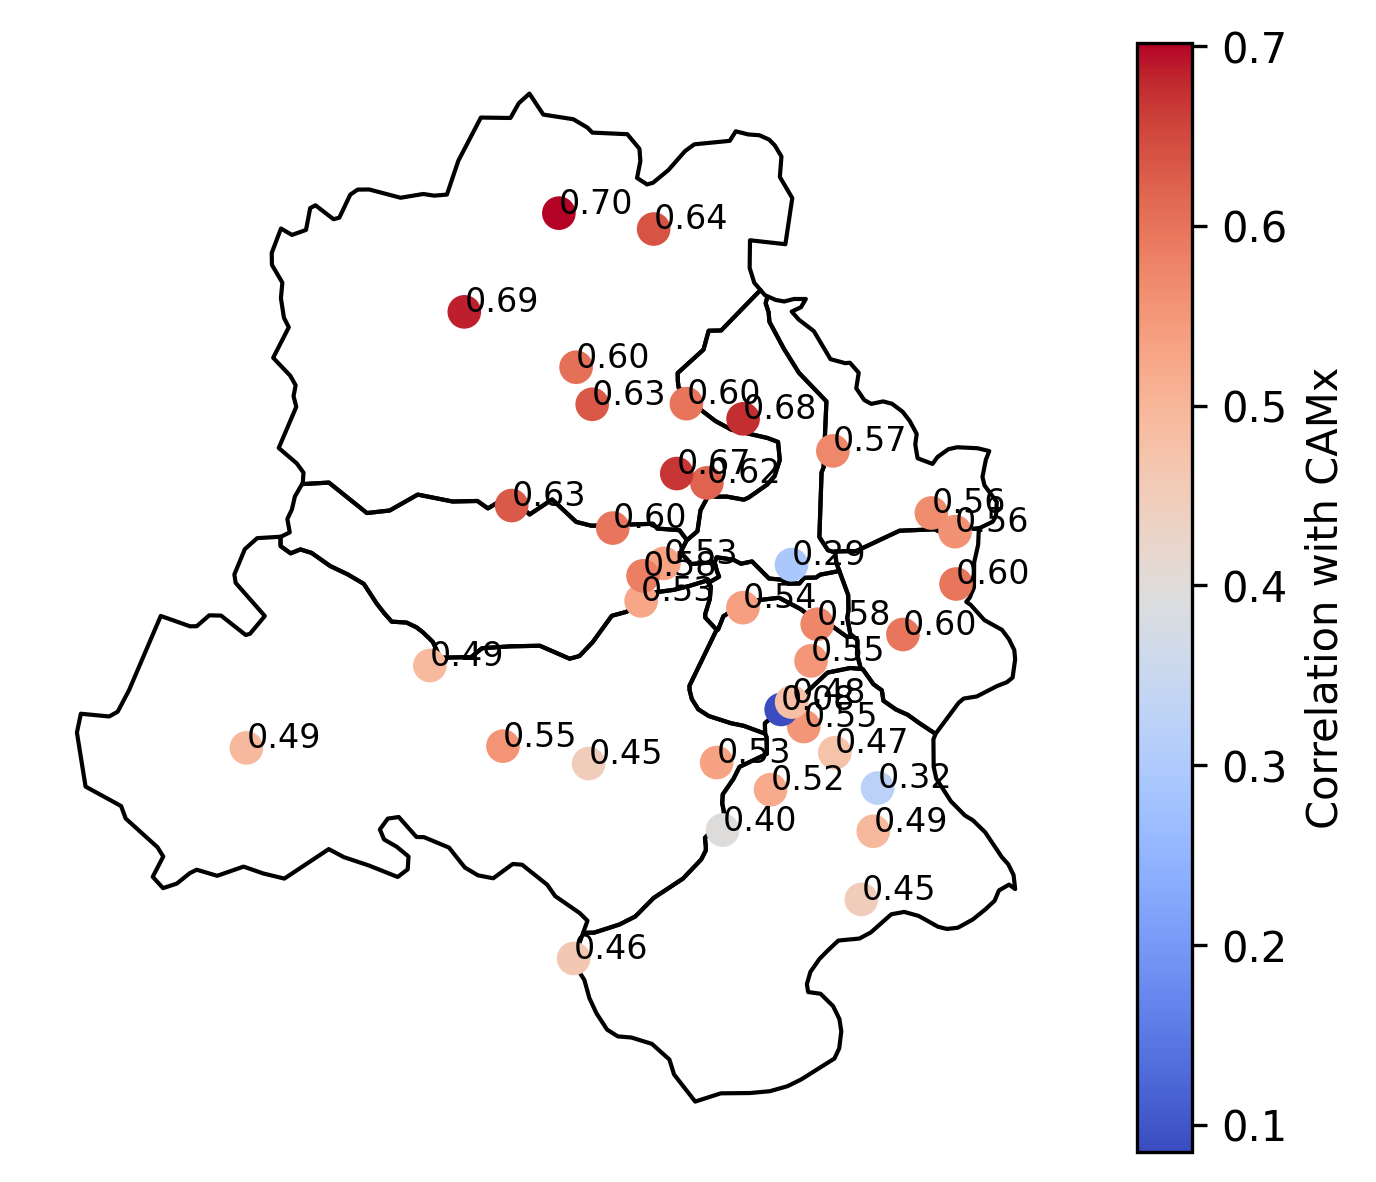

In [47]:
gdf = load_shapefile("delhi")
fig = plt.figure(dpi=300)
ax = fig.gca()
gdf.plot(color="none", ax=ax)
ax.axis("off");
mappable = ax.scatter(station_ds.longitude, station_ds.latitude, c=np.array(corr_list), cmap="coolwarm", s=50)
# annotate the stations
for i in range(len(corr_list)):
    ax.annotate(f"{corr_list[i]:.2f}", (station_ds.longitude[i], station_ds.latitude[i]), fontsize=8)
plt.colorbar(mappable, label="Correlation with CAMx")

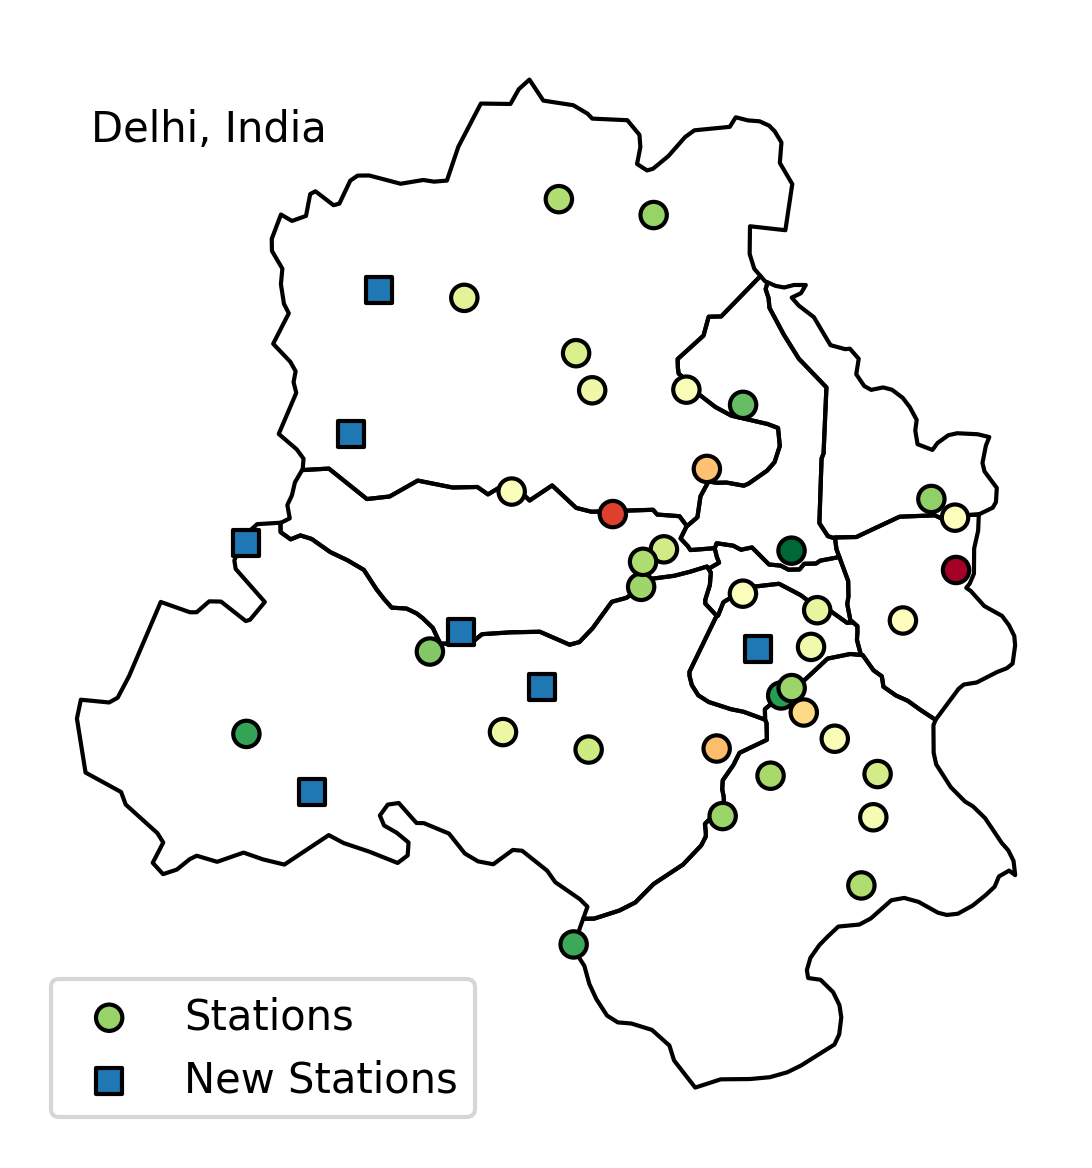

In [13]:
# plt.rcParams.update(bundles.icml2022())
fig, ax = plt.subplots(dpi=300)
gdf.plot(color="none", edgecolor="black", ax=ax)
plt.scatter(
    delhi["longitude"],
    delhi["latitude"],
    # color="tab:blue",
    label="Stations",
    s=40,
    c=delhi.isel(time=0)["PM2.5"].values,
    cmap="RdYlGn_r",
    edgecolor="k",
)
np.random.seed(1)
plt.scatter(
    np.random.uniform(delhi["longitude"].min(), delhi["longitude"].max(), 7),
    np.random.uniform(delhi["latitude"].min(), delhi["latitude"].max(), 7),
    # color="tab:blue",
    label="New Stations",
    s=40,
    # c=delhi.isel(time=0).values,
    cmap="RdYlGn_r",
    edgecolor="k",
    marker="s",
)
# plt.colorbar(label="PM2.5")
Lons, Lats = np.meshgrid(camx.longitude, camx.latitude)
# plt.scatter(
#     Lons.ravel(),
#     Lats.ravel(),
#     c=camx_2023.isel(time=0, lag=0).values.ravel(),
#     label="CAMx",
#     s=1,
#     alpha=0.5,
#     cmap="RdYlGn_r",
# )
plt.text(x=76.85, y=28.85, s="Delhi, India")
plt.legend(loc="lower left")
# turn off axis
plt.gca().axis("off")
# plt.xlabel("Longitude")
# plt.ylabel("Latitude")
plt.show()
# plt.savefig("camx_and_stations.pdf")


## Lab

In [ ]:
a = np.random.rand(5)
print(a)
np.argpartition(a, 3)


[0.06605139 0.888819   0.8384497  0.74334194 0.16201181]


array([0, 4, 3, 2, 1])